# Comparison of DFT and FFT
In this Jupyter notebook I compare different algorithms to obtain the Discrete Fourier Transform.

First import the numpy stuff:

In [1]:
import numpy as np
from numpy import exp, pi

Below is a naive/brute force implementation of the DFT:

In [2]:
def DFT_brute_force(signal, inverse=False):
    """
    Computes the DFT in a naive way
    Input: 
        signal    1d-numpy array
                  signal
        inverse   bool (OPTIONAL)
                  if true, compute the inverse DFT
    Returns:
        transformed  1d-numpy array
                  Fourier Transform of the signal
                
    """
    n = len(signal)
    transformed = np.zeros(signal.shape, dtype=complex)
    for k in range(n): # for each transformed element
        for l in range(n): # compute sum in loop
            if not inverse:
                transformed[k] += signal[l] * exp(-2j * pi * k * l / n)
            else: 
                transformed[k] += signal[l] * exp(2j * pi * k * l / n)
    return transformed

It is a bit more efficient to solve the DFT with a single matrix-vector-multiplication

In [3]:
def DFT(signal, inverse=False):
    """
    Computes the DFT by a matrix-vector-multiplication
    Input: 
        signal    1d-numpy array
                  signal
        inverse   bool (OPTIONAL)
                  if true, compute the inverse DFT
    Returns:
        transformed  1d-numpy array
                  Fourier Transform of the signal
                
    """
    n = len(signal)
    k_array = np.arange(n)
    if not inverse:
        W = exp(-2j * pi * np.outer(k_array, k_array) / n) # DFT matrix
    else:
        W = exp(2j * pi * np.outer(k_array, k_array) / n) # inverse DFT matrix
    return W.dot(signal) # matrix vector product

This recursive FFT algorithm enables a better time complexity when obtaining the Discrete Fourier Transform of a signal:

In [4]:
def FFT(signal, cutoff=16, w=None):
    """
    Computes the FFT with a recursive implementation of the Cooley-Tukey algorithm
    Inputs:
        signal     1d-numpy array
                   signal of length 2**x, type(x)=int
        cutoff     int, OPTIONAL 2**x
                   size of the 'lowest split level' to compute the DFT on
    Returns:
        output     1d-numpy array
                   FFT of the signal
    """
    n = len(signal)
    if (n == 1): # trivial case
        return signal
    if (n <= cutoff): # cutoff with DFT
        return DFT(signal)
    output = np.zeros(n, dtype=complex)
    m = int(n/2)
    signal = signal.reshape(m, 2) # split signal in even, odd
    even, odd = signal[:,0], signal[:,1]
    if w is None: # compute twiddle factors if not given
        w = np.exp(-2j * np.pi * np.arange(m) / n)
    else:
        w = w[0:n-1:2] # reuse twiddle factors
    e = FFT(even, cutoff, w)     # even FFT
    o = w * FFT(odd, cutoff, w)  # odd FFT
    output[:m] = e + o
    output[m:] = e - o
    return output

Just some test function to validate the implementations:

In [5]:
import timeit
import statistics
def test(func, n=2**8, samples=10):
    """
    Test function
    """
    data = np.random.randint(-10, 10, size=n) + 1j*np.random.randint(-10, 10, size=n)
    compare = np.fft.fft(data) - func(data)
    if max(abs(compare)) > 1e-6:
        print('Implementation wrong!')
        return
    f = lambda: func(data)
    times = timeit.Timer(f).repeat(samples, 1)
    mean = statistics.mean(times)
    return mean

Execution times for the different algorithms with data size n=256:

In [6]:
test(DFT_brute_force)

0.09432040999999991

In [7]:
test(DFT)

0.004579759999999844

In [8]:
test(FFT)

0.0006714600000000459

Test function to run benchmarks for different FFT implementations:

*You have to reduce the data sizes, if your computer is rather slow!*

In [9]:
import math
import matplotlib.pyplot as plt
from IPython.display import HTML, display
#import tabulate
%matplotlib notebook
def testCycle(funcs, start=2**1, end=2**8, samples=10, verbose=False):
    n = start
    iterations = []
    times = [[] for f in funcs]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    while n <= end:
        row = []
        iterations.append(n)
        if verbose:
            ax.clear()
            plt.xscale("log", basex=2)
            plt.yscale("log")
        for i, func in enumerate(funcs):
            time = test(func, n, samples)
            if time < 1e-3:
                time = test(func, n, int(samples/math.sqrt(time)))
            times[i].append(time)
            row.append(str(time))
            if verbose:
                ax.plot(iterations, times[i])
        if verbose:
            fig.canvas.draw()
        print(n, '|', ' | '.join(row))
        n *= 2
    #for i, func in enumerate(funcs):
    #    plt.plot(iterations, times[i])
    #plt.xscale("log", basex=2)
    #plt.yscale("log")
    return times

<IPython.core.display.Javascript object>


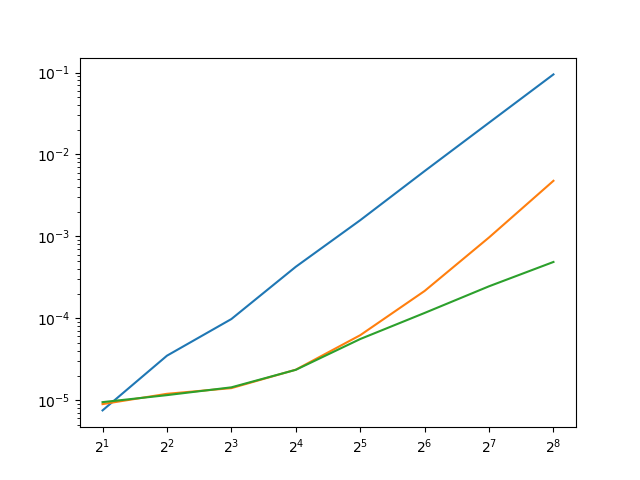

2 | 7.511406460352264e-06 | 8.960325732895472e-06 | 9.47500868960501e-06
4 | 3.4960705160949154e-05 | 1.197528885577521e-05 | 1.153751355258018e-05
8 | 9.795301681501488e-05 | 1.4047224425066406e-05 | 1.4363752913698552e-05
16 | 0.00042573320079528955 | 2.358350217082514e-05 | 2.350959920831847e-05
32 | 0.001575499999999863 | 6.217648979603679e-05 | 5.583216155578457e-05
64 | 0.006271389999999854 | 0.00021570237341764396 | 0.00011625831509847613
128 | 0.02442970000000031 | 0.0009705540123457171 | 0.000245965639445435
256 | 0.09494430999999963 | 0.004771719999999391 | 0.00048726586956526476


In [10]:
testCycle((DFT_brute_force, DFT, FFT), verbose=True);

<IPython.core.display.Javascript object>


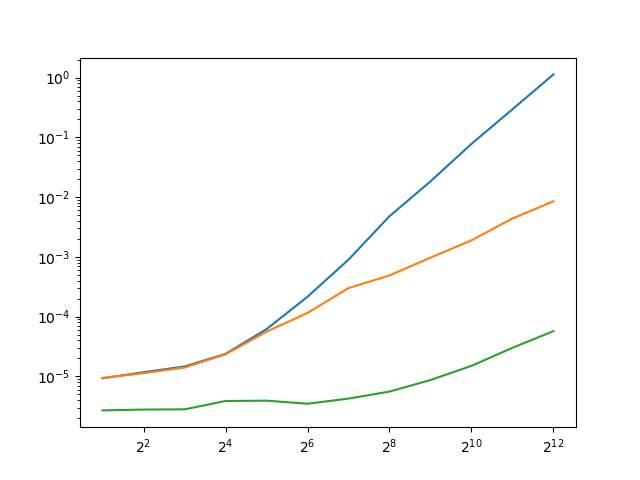

2 | 9.295829228237787e-06 | 9.42327728323209e-06 | 2.6908752327900512e-06
4 | 1.1716537044676226e-05 | 1.1269575971716032e-05 | 2.777461399612248e-06
8 | 1.4635483870956931e-05 | 1.4017298874469471e-05 | 2.804479483969275e-06
16 | 2.376538661129535e-05 | 2.3360341463434405e-05 | 3.864943490982074e-06
32 | 6.162748154222253e-05 | 5.588669291339928e-05 | 3.914560770128376e-06
64 | 0.00021494999999999465 | 0.00011526543730249153 | 3.480616915410835e-06
128 | 0.0008991797653958907 | 0.0003008078341014084 | 4.2400722021575295e-06
256 | 0.0047887400000000465 | 0.0004884015118790959 | 5.556865219568299e-06
512 | 0.018363689999998913 | 0.0009707703470031618 | 8.670211461843297e-06
1024 | 0.07786697999999959 | 0.0018922300000003389 | 1.4999682791463898e-05
2048 | 0.29605107 | 0.004389869999999263 | 3.0015298087785148e-05
4096 | 1.134866310000001 | 0.008521209999999257 | 5.7174427782134773e-05


In [11]:
testCycle([DFT, FFT, np.fft.fft], end=2**12, verbose=True);

<IPython.core.display.Javascript object>


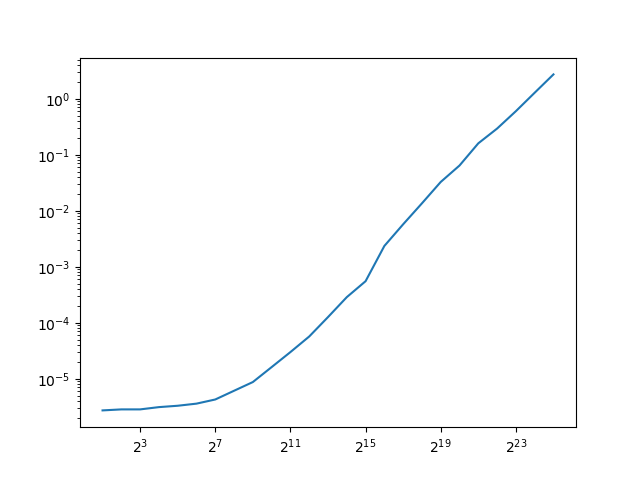

2 | 2.726859283048198e-06
4 | 2.8412061205912038e-06
8 | 2.8419301773227555e-06
16 | 3.120861972746678e-06
32 | 3.3011814836869294e-06
64 | 3.600845360837512e-06
128 | 4.272338998134728e-06
256 | 6.1162320538741135e-06
512 | 8.747177296322127e-06
1024 | 1.617495076795375e-05
2048 | 3.0001920903941455e-05
4096 | 5.6924137931084054e-05
8192 | 0.00012647780269055855
16384 | 0.00028706689774699815
32768 | 0.0005529637231504092
65536 | 0.002355279999999027
131072 | 0.005742430000001519
262144 | 0.013589290000000176
524288 | 0.03273394000000067
1048576 | 0.0643405599999987
2097152 | 0.1602402100000006
4194304 | 0.29386507999999906
8388608 | 0.6009140600000009
16777216 | 1.2827518099999993
33554432 | 2.725985800000001


In [12]:
testCycle([np.fft.fft], end=2**23, verbose=True);